In [1]:
import numpy as np
import operator
# from numpy.linalg import norm
from numpy.linalg import inv
from numpy.linalg import det
import math
from functools import reduce
import pandas as pd
# %matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('seaborn-whitegrid')
import time

norm = lambda A: np.linalg.norm(A, ord=2)

### Решение ОДУ сеточным методом

In [2]:
def get_nodes(a, b, n):
    # Возвращает равноотстоящие узлы
    return np.linspace(a, b, n)

In [3]:
def lattice(t, q, r, f, a, b, n, alpha, beta, a_ord, b_ord):
    # Строит сетку для n разбиений
    A = np.zeros((n + 1, n + 1))
    F = np.zeros(n + 1)
    h = (b - a) / n
    x = get_nodes(a, b, n + 1)
    
    A[0][a_ord - 1] = 1
    F[0] = alpha
    A[-1][-b_ord] = 1
    F[-1] = beta

    for i in range(1, n):
        A[i][i + 1] =  1 / h**2  * t(x[i]) + q(x[i]) / (2 * h) 
        A[i][i]     = -2 / h**2  * t(x[i]) - r(x[i])
        A[i][i - 1] =  1 / h**2  * t(x[i]) - q(x[i]) / (2 * h)
        F[i] = f(x[i])

    return np.linalg.solve(A, F)

In [4]:
def delta(v1, v2, n):
    # Оценка погрешности методом Ричардсона
    d = np.zeros(n + 1)
    for i in range(n + 1):
        if i % 2 == 0:
            d[i] = (v2[i] - v1[i // 2]) / 3
    for i in range(n + 1):
        if i % 2 == 1:
            d[i] = (d[i - 1] + d[i + 1]) / 2

    return norm(d)

In [5]:
def adjust(v1, v2, n):
    # Уточнение с помощью метода Ричардсона
    d = np.zeros(n + 1)
    for i in range(n + 1):
        if i % 2 == 0:
            d[i] = (v2[i] - v1[i // 2]) / 3
    for i in range(n + 1):
        if i % 2 == 1:
            d[i] = (d[i - 1] + d[i + 1]) / 2

    return v2 + d

In [6]:
def draw(best_solution, ns, errors, n, u=None):
    fig, ax = plt.subplots(1, 2, figsize=(30, 10), dpi=80)
    ax[0].plot(get_nodes(a, b, n + 1), best_solution, label='~u')

    if u:
        nodes = get_nodes(a, b, int(1e5))
        u_vals = np.array(list(map(u, nodes)))
        ax[0].plot(nodes, u_vals, label='u')
        
        nodes = get_nodes(a, b, n + 1)
        u_vals = np.array(list(map(u, nodes)))
        print("diff with u:", norm(u_vals - best_solution))
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 20})
    
    ax[1].set_yscale('log')
    ax[1].set_xscale('log', base=2)
    if norm(np.array(errors)):
        ax[1].plot(ns, errors)
    
    k = 0
    ticks = []
    while 4 * 2**k <= n:
        ticks.append(4 * 2**k)
        k += 1

    ax[1].xaxis.set_ticks(ticks)

In [7]:
def solve(t, q, r, f, a, b, alpha, beta, a_ord=1, b_ord=1, MAX_ITERS=1, u=None):
    # Метод сеток
    ns, errors = [], []

    n = 4

    v1 = lattice(t, q, r, f, a, b, n, alpha, beta, a_ord, b_ord)
    n *= 2
    v2 = lattice(t, q, r, f, a, b, n, alpha, beta, a_ord, b_ord)


    iters = 0
    d = delta(v1, v2, n)
    ns.append(n)
    errors.append(d)
    
    while iters < MAX_ITERS - 1:
        n *= 2
        v1, v2 = v2, lattice(t, q, r, f, a, b, n, alpha, beta, a_ord, b_ord)        
        d = delta(v1, v2, n)
        ns.append(n)
        errors.append(d)
        iters += 1

    best_solution = adjust(v1, v2, n)
    
    draw(best_solution, ns, errors, n, u)

***
#### Тесты

In [8]:
# -(p(x) * y')' + q(x) * y' + r(x) * y = f(x)

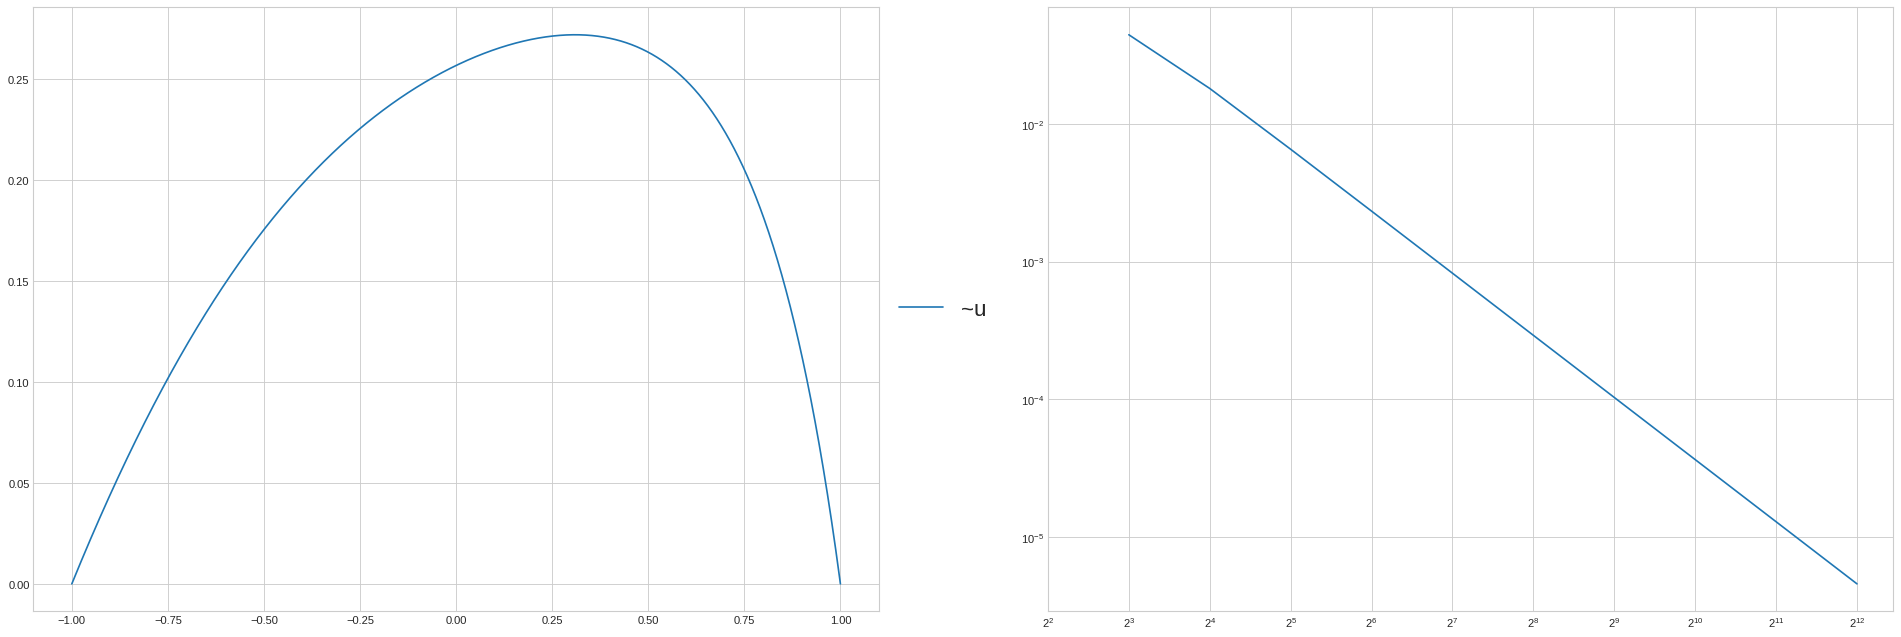

In [9]:
# Вариант 6
t = lambda x: (x - 2) / (x + 2)
q = lambda x: x
r = lambda x: 1 - np.sin(x)
f = lambda x: x**2

a, b = -1, 1
alpha, beta = 0, 0
solve(t, q, r, f, a, b, alpha, beta, MAX_ITERS=10)

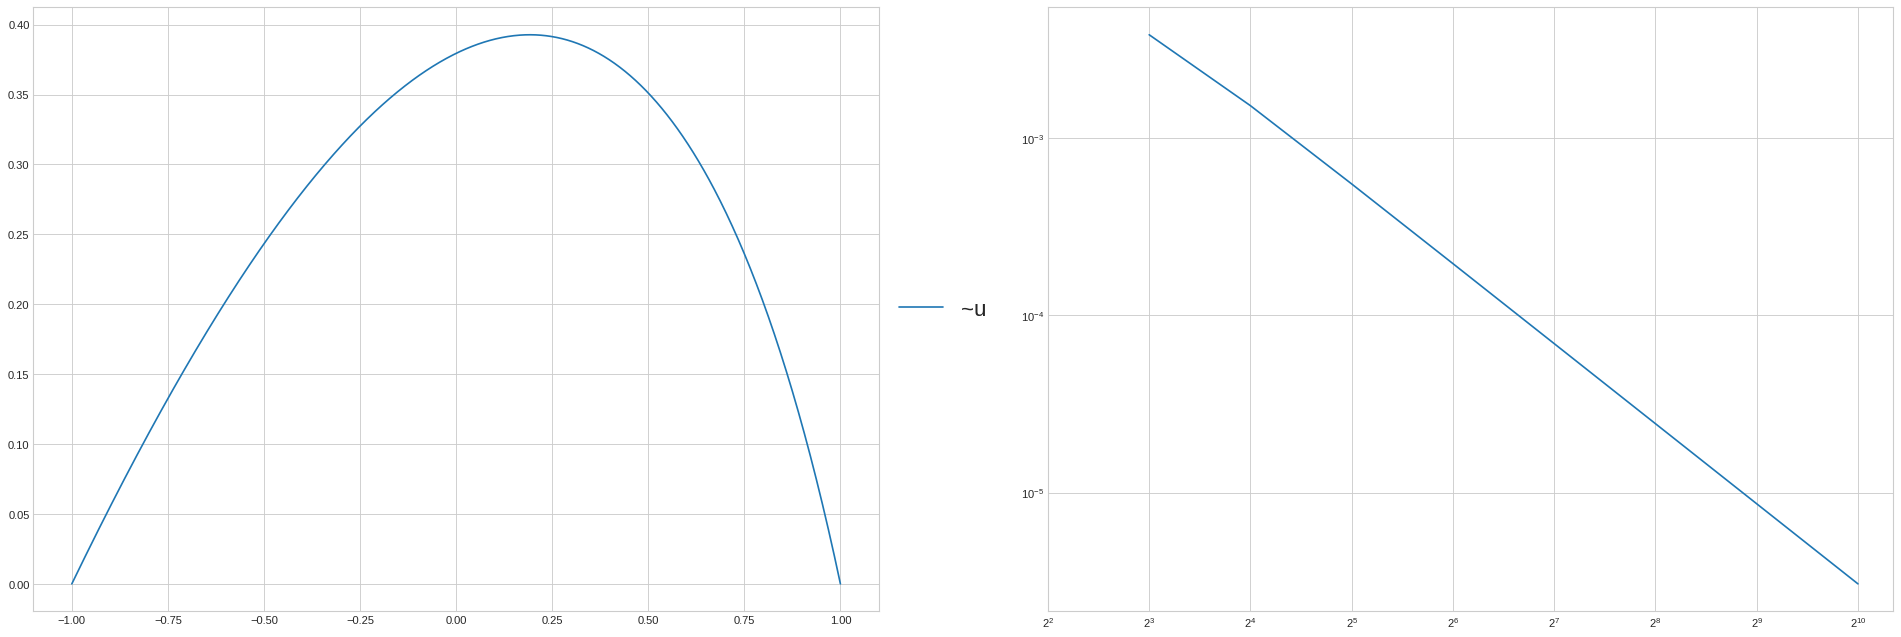

In [10]:
# Вариант 11
t = lambda x: -(7 - x) / (8 + 3 * x)
q = lambda x: 1 + x / 3
r = lambda x: 1 - np.exp(x / 2) / 2
f = lambda x: 0.5 - x / 3

a, b = -1, 1
alpha, beta = 0, 0
solve(t, q, r, f, a, b, alpha, beta, MAX_ITERS=8)

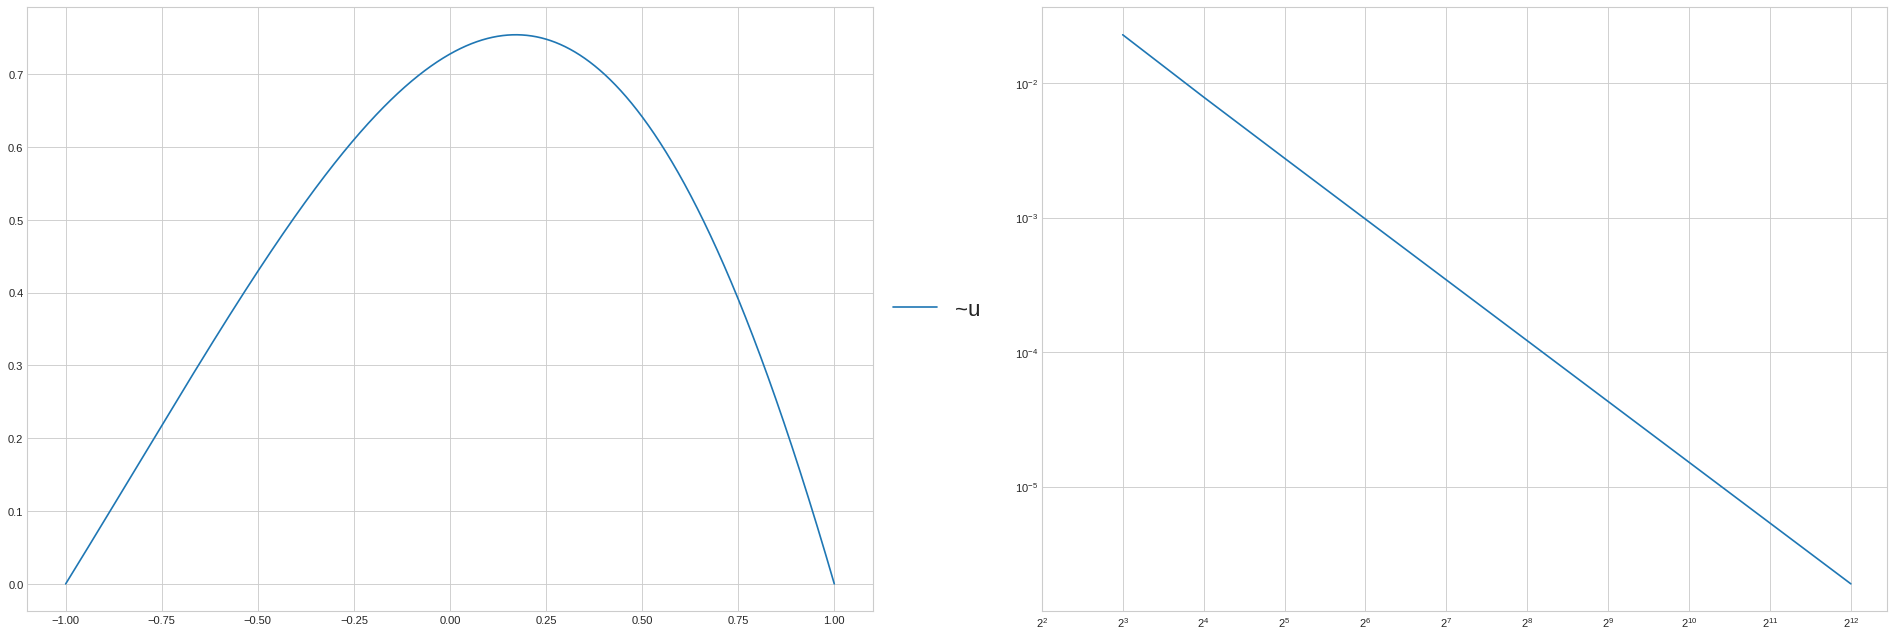

In [11]:
# Вариант 8
t = lambda x: -(4 + x) / (5 + 2 * x)
q = lambda x: (1 - x) / 2
r = lambda x: np.log(3 + x) / 2
f = lambda x: 1 + x / 3

a, b = -1, 1
alpha, beta = 0, 0
solve(t, q, r, f, a, b, alpha, beta, MAX_ITERS=10)

diff with u: 0.0


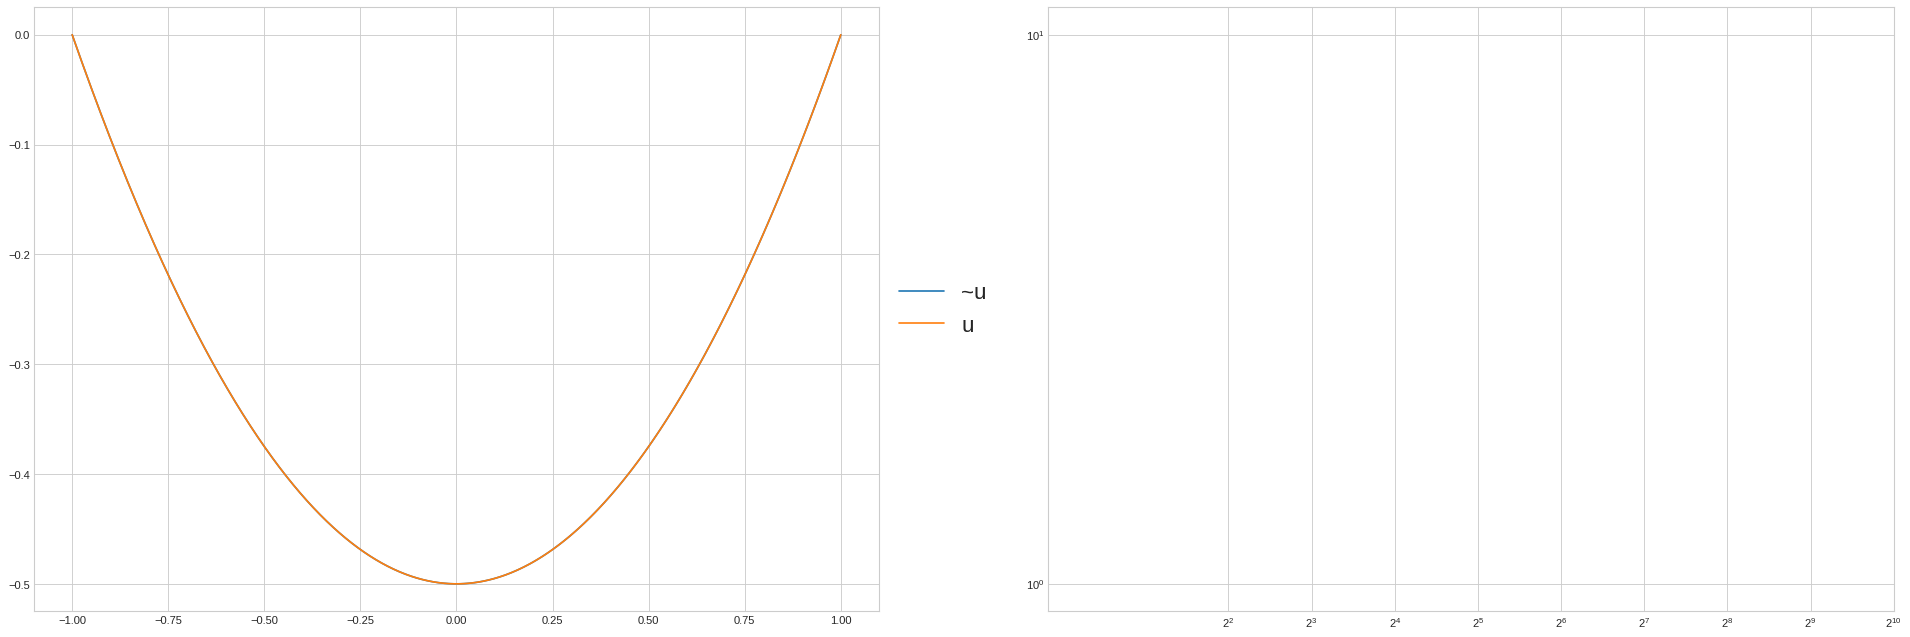

In [12]:
# u'' = 1
t = lambda x: 1
q = lambda x: 0
r = lambda x: 0
f = lambda x: 1

a, b = -1, 1
alpha, beta = 0, 0

u = lambda x: (x ** 2 - 1) / 2

solve(t, q, r, f, a, b, alpha, beta, MAX_ITERS=8, u=u)


diff with u: 1.892574036435802e-09


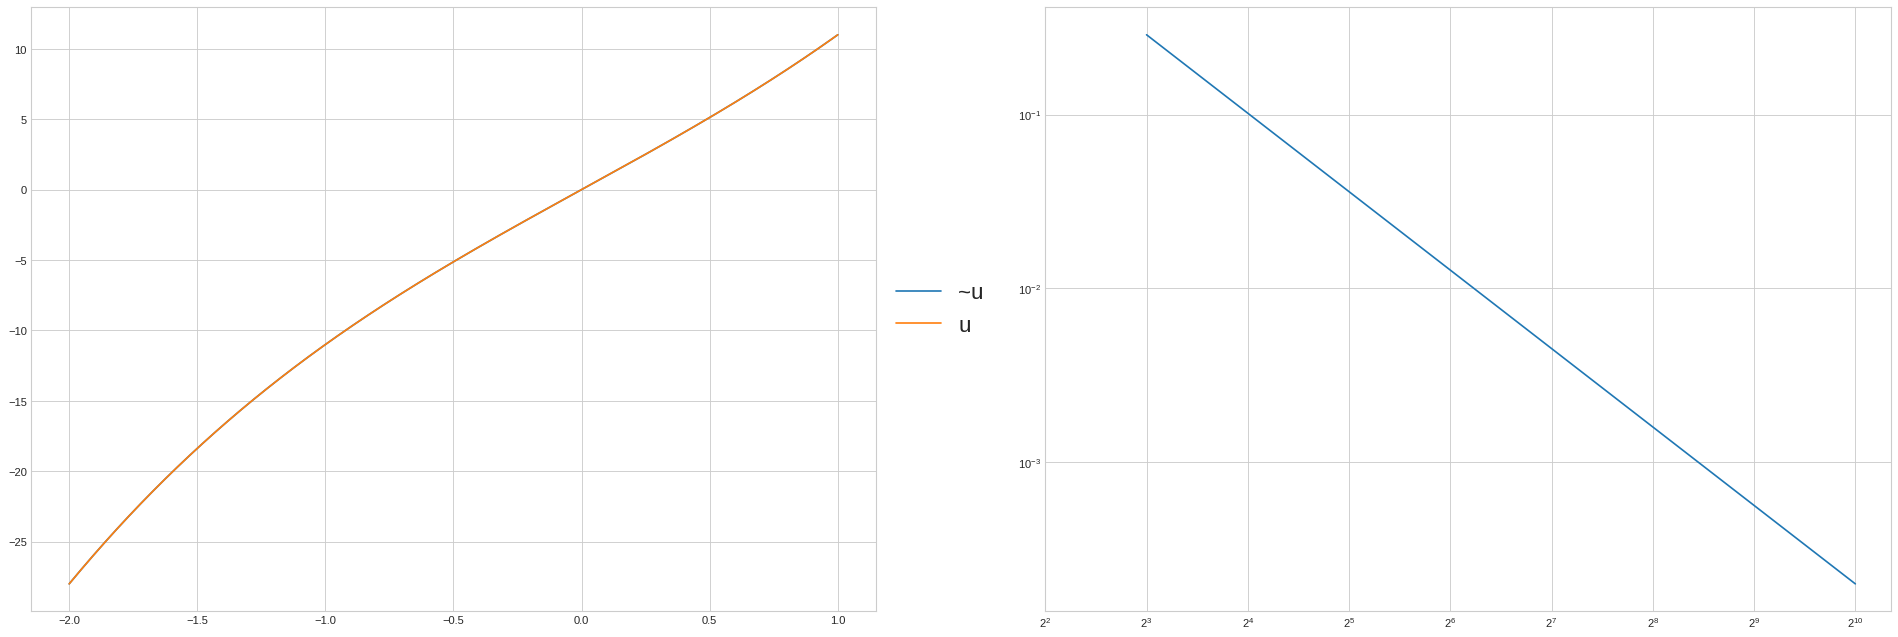

In [13]:
# u = x**3 + 10 * x
t = lambda x: 1
q = lambda x: 1
r = lambda x: 0
f = lambda x: 6 * x + 3 * x**2 + 10

a, b = -2, 1
alpha, beta = -28, 11

u = lambda x: x**3 + 10 * x

solve(t, q, r, f, a, b, alpha, beta, MAX_ITERS=8, u=u)


diff with u: 0.0005549287829119509


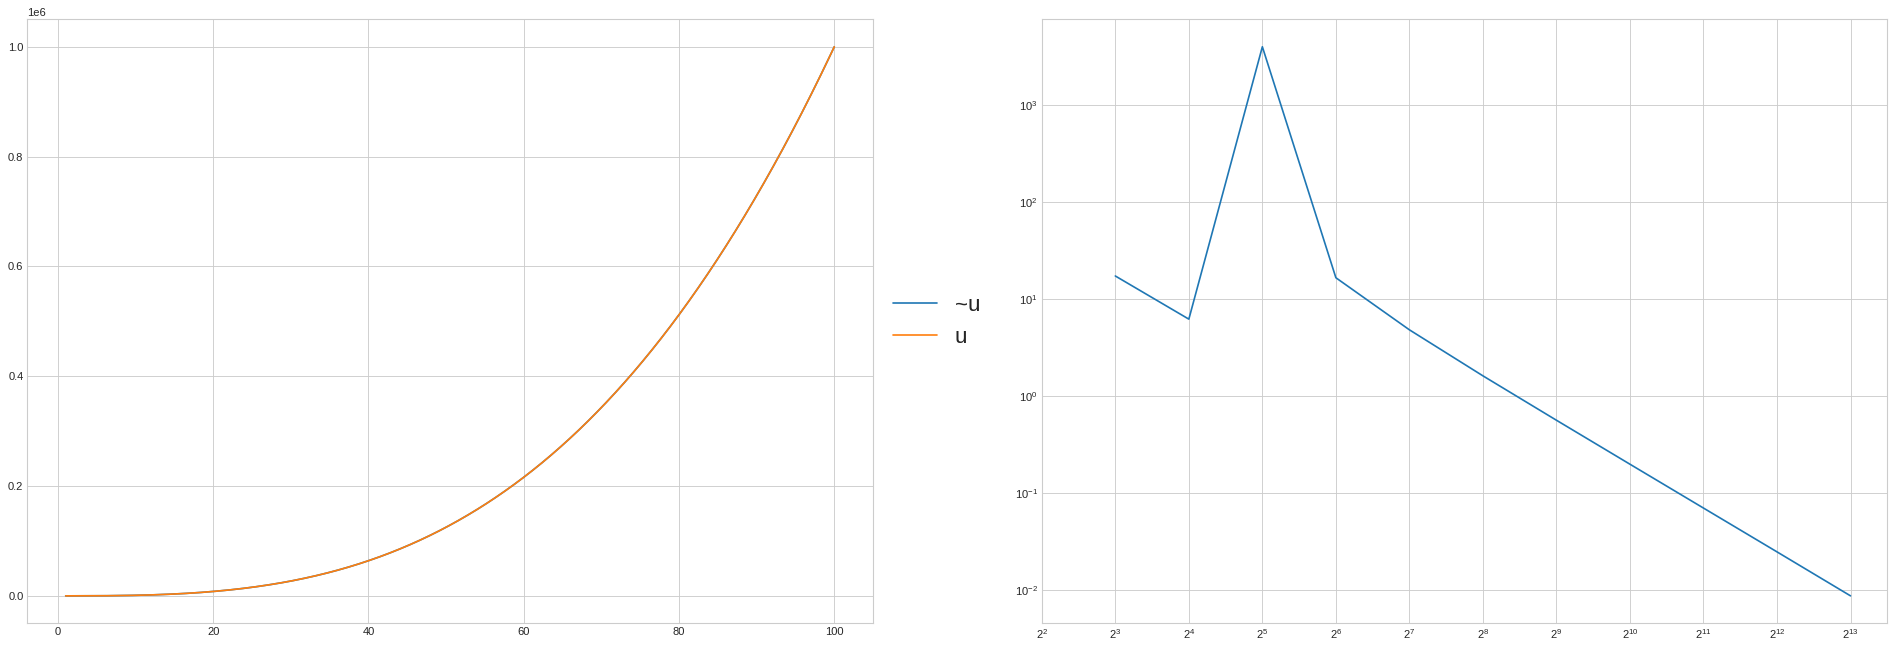

In [14]:
# u = 10sin(x) + 1/x + ln(x) + x**3
t = lambda x: 1
q = lambda x: 0
r = lambda x: 0

f = lambda x: (6 * x**4 -x + 2) / x**3 - 10 * np.sin(x)
a, b = 1, 100

u = lambda x: 10 * np.sin(x) + 1 / x + np.log(x) + x**3

alpha, beta = u(a), u(b)



solve(t, q, r, f, a, b, alpha, beta, MAX_ITERS=11, u=u)


diff with u: 0.0010936265957959606


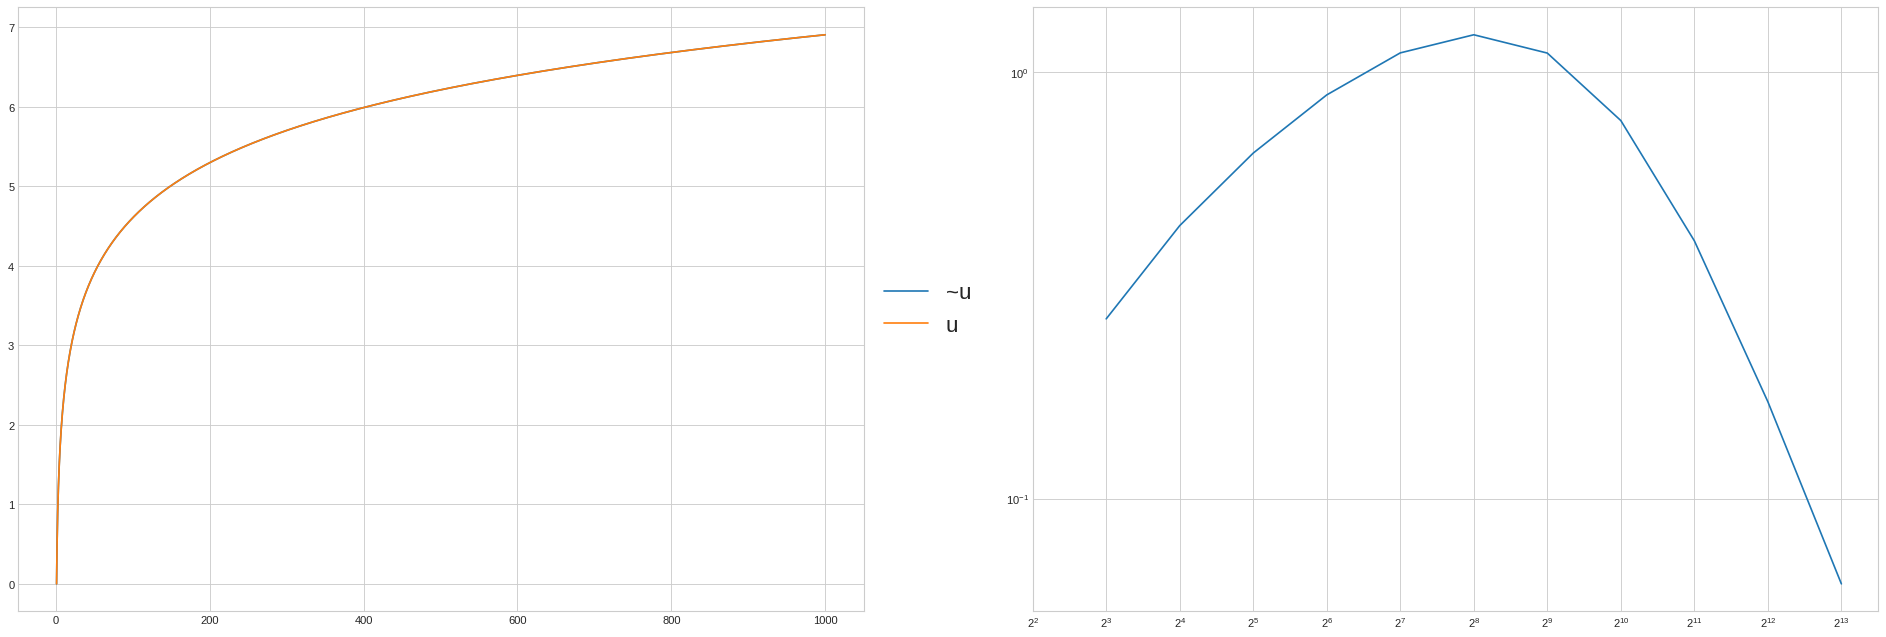

In [15]:
# u = 10sin(x) + 1/x + ln(x) + x**3
t = lambda x: 1
q = lambda x: 0
r = lambda x: 0

f = lambda x: -1 / x**2
a, b = 1, 1000

u = lambda x: np.log(x)

alpha, beta = u(a), u(b)



solve(t, q, r, f, a, b, alpha, beta, MAX_ITERS=11, u=u)
